In [1]:
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller test
from statsmodels.stats.diagnostic import acorr_ljungbox # White noise test
import statsmodels.api as sm # BIC
from statsmodels.tsa.arima.model import ARIMA # ARIMA model
from statsmodels.stats.stattools import durbin_watson # DW test
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings("ignore")

# Data processing -> Smoothing -> Ordering -> Modeling -> Forecasting -> Evaluating

### Data processing

In [3]:
# Import data
sales_tv = pd.read_csv("/Users/Xianghao/Desktop/M5/sales_train_validation.csv")
sales_te = pd.read_csv("/Users/Xianghao/Desktop/M5/sales_train_evaluation.csv")
cal = pd.read_csv("/Users/Xianghao/Desktop/M5/calendar.csv")

In [4]:
# A bit of preprocessing and df transformation

# Dropping some columns and transposing the table to time series format
sales_te_pre = sales_te.drop(["item_id","dept_id","cat_id","store_id","state_id"], axis=1).T 
sales_te_pre = sales_te_pre.set_axis(sales_te_pre.iloc[0,:], axis="columns").drop(["id"], axis=0)

sales_tv_pre = sales_tv.drop(["item_id","dept_id","cat_id","store_id","state_id"], axis=1).T 
sales_tv_pre = sales_tv_pre.set_axis(sales_tv_pre.iloc[0,:], axis="columns").drop(["id"], axis=0)

# Setting the index of Calendar dataset to match sales dataset
cal.set_index("d", inplace=True)

# joining two dataset by index
data_evaluation = sales_te_pre.join(cal, how="left")
data_validation = sales_tv_pre.join(cal, how="left")

data_evaluation.drop(["event_name_1", "event_type_1", "event_type_2", "event_name_2", "snap_CA", "snap_TX", "snap_WI",
                "wm_yr_wk", "weekday", "wday", "month", "year"],
                axis = 1,
                inplace = True)
data_evaluation.set_index("date", inplace = True)

data_validation.drop(["event_name_1", "event_type_1", "event_type_2", "event_name_2", "snap_CA", "snap_TX", "snap_WI",
                "wm_yr_wk", "weekday", "wday", "month", "year"],
                axis = 1,
                inplace = True)
data_validation.set_index("date", inplace = True)

In [7]:
#def Splitting_validation(): #Splitting validation data  
#    train_data = data_validation.iloc[0:len(data_validation)-28]
#    test_data = data_validation.iloc[len(data_validation)-28:]
#    return train_data,test_data

In [5]:
# Splitting evaluation data
def Splitting_evaluation(): 
    train_data = data_evaluation.iloc[0:len(data_evaluation)-28]
    test_data = data_evaluation.iloc[len(data_evaluation)-28:]
    
    return train_data,test_data

In [9]:
#train_data,test_data = Splitting_validation()
#row_train_data = train_data 

In [6]:
# Get train data and test data
train_data,test_data = Splitting_evaluation()
row_train_data = train_data

### Smoothing and Ordering

In [7]:
# First difference
def stationarity(timeseries): 
    diff1 = timeseries.diff(1).dropna() # First difference for stationarity
    
    return diff1

In [8]:
## Augmented Dickey-Fuller test
# Stationarity test for high order of autocorrelations
def ADF_test(timeseries): ## Stationarity test for high order of autocorrelations
    adftest = adfuller(np.array(timeseries), autolag='AIC')
    if adftest[0] < adftest[4]["5%"] and adftest[1] < 10**(-3): 
    # adftest[0] = ADF results, 
    # adftest[4] = Dickey-Fuller critical values: 1%: -3.43, 5%: -2.86, 10%: -2.57
    # adftest[1] = P-value, 
    
        #print("Stationarity, we can continue")
        return True # Stationarity
        
    else:
        #print("Non-Stationarity")
        return False # Non-Stationarity
    

def random_test(timeseries) : # White noise test
    p_value = acorr_ljungbox(timeseries, lags=1).iloc[0,1] 
    if p_value < 0.05: 
        #print("Not White noise, we can continue")
        return  True
    else:
        #print("White noise")
        return False

In [10]:
#Time series ordering ARIMA(?,d,?)
def detetminante_order_BIC(timeseries): #BIC

    BIC = sm.tsa.arma_order_select_ic(timeseries,max_ar=4,\
           max_ma=2,ic='bic')['bic_min_order']
    return BIC

### Modeling

In [12]:
def ARIMA_model(train_data, order):
    arima = ARIMA(train_data, order=(bic[0],dif,bic[1])).fit() 

    #print(arima.forecast(28))
    #print(arima.summary())
    in_sample_pred = arima.predict()
    out_sample_pred = arima.predict(start=len(train_data)-1,end = len(train_data)+27, \
                              dynamic=True)
    #print('arima', arima)
    #print('in_sample_pred', in_sample_pred )
    #print('out_sample_pred', out_sample_pred )
    

    return arima, in_sample_pred, out_sample_pred

### Evaluating

In [13]:
def evaluate_model(model,train_data,predict_data):
    
    resid = model.resid  # Residuals
    # Use the D-W test to test the autocorrelation of the residuals
    return durbin_watson(resid.values)

In [15]:
def draw_picture(row_train_data,out_sample_pred,test_data): 

    x = []
    for i in range(28):
        x.append(i+1)
    x = np.array(x)

    y1 = np.array(test_data)
    y2 = np.array(out_sample_pred[1:])
    
    plt.plot(x,y1,color='blue')
    plt.plot(x,y2,color='red')
    plt.show()

An example of stationarity

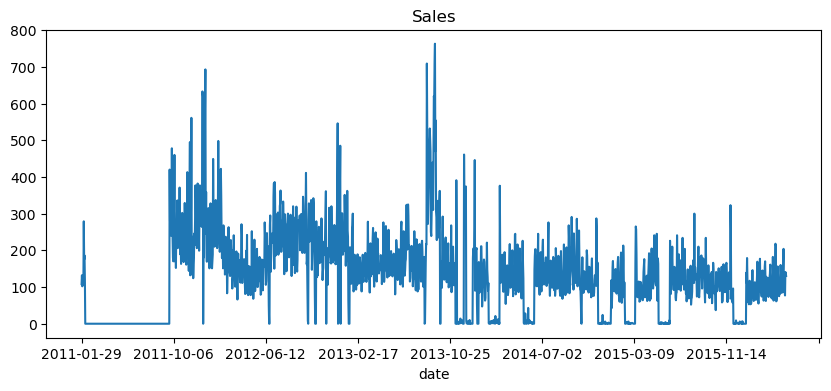

In [16]:
train_data_single = train_data.loc[:, 'FOODS_3_090_CA_3_evaluation']
row_train_data_single = train_data_single
train_data_single.plot(figsize = (10,4))
plt.title("Sales")

plt.show()

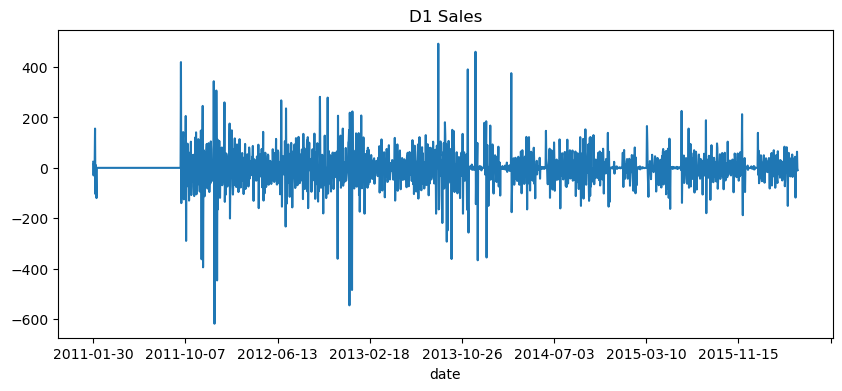

In [17]:
diff1 = stationarity(train_data_single)
diff1.plot(figsize = (10,4))
plt.title("D1 Sales")

plt.show()

#### Main code

Bad
Good


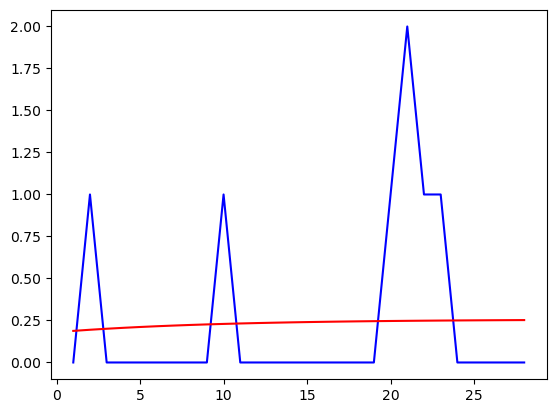

Bad
Bad
Good


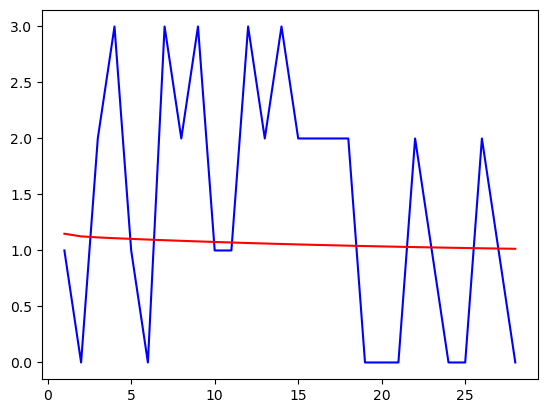

Bad
Good


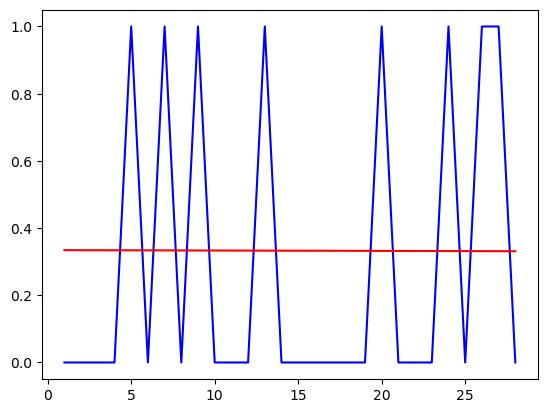

In [42]:
# See below for details
for column in train_data :
    
    train_data_single = train_data.loc[:, [column]]
    ADF_test(train_data_single)
    random_test(train_data_single)
    #Time series ordering ARIMA(p,?,q)
    if ADF_test(train_data_single) == 1 and random_test(train_data_single) == 1 :
        dif = 0
    elif ADF_test(stationarity(train_data_single)) == 1 and random_test(stationarity(train_data_single)) == 1 :
        train_data_single = train_data_single.diff(1)
        dif = 1
    else :
        train_data_single = train_data_single.diff(2)
        dif = 2
    
    bic = detetminante_order_BIC(train_data_single)

    arima, in_sample_pred, out_sample_pred = ARIMA_model(train_data_single.astype(np.float32), order=(bic[0],dif,bic[1]))

    dw_test = evaluate_model(arima, train_data_single, in_sample_pred)
    
    if dw_test < 2.1 and dw_test >1.9 :
        
        #dataset_name = out_sample_pred.reset_index(drop=True)
        #dataset_name.to_csv("eval_preds.csv", index=True)  # export data
        print('Good')
        draw_picture(row_train_data.loc[:, [column]], out_sample_pred, test_data.loc[:, [column]])
        #dataset_name = out_sample_pred.reset_index(drop=True)
    else:
        print('Bad')
    

Time series ordering ARIMA(p,?,q)

In [19]:
#Time series ordering ARIMA(p,?,q)
#if ADF_test(train_data_single) == 1 and random_test(train_data_single) == 1 :
#    dif = 0
#elif ADF_test(stationarity(train_data_single)) == 1 and random_test(stationarity(train_data_single)) == 1 :
#    train_data_single = train_data_single.diff(1)
#    dif = 1
#else :
#    train_data_single = train_data_single.diff(2)
#    dif = 2

#print(dif)

0


BIC test

In [20]:
#bic = detetminante_order_BIC(train_data_single)
#print(bic)

(3, 1)


Prediction

In [21]:
#arima, in_sample_pred, out_sample_pred = ARIMA_model(train_data_single.astype(np.float32), order=(bic[0],dif,bic[1]))

Evaluation

In [22]:
#dw_test = evaluate_model(arima, train_data_single, in_sample_pred)
#print(dw_test)
#if dw_test < 2.1 and dw_test >1.9 :
#    print('Good')

2.009514745395253
Good


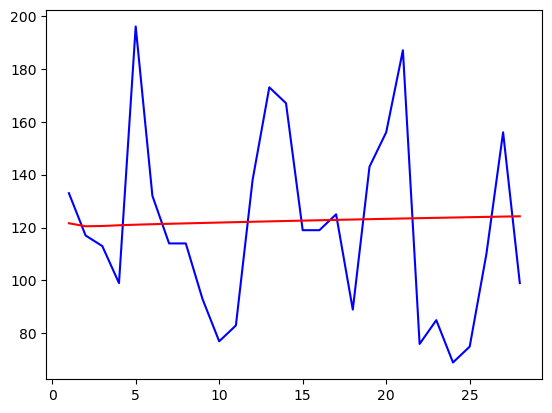

In [25]:
#draw_picture(row_train_data_single, out_sample_pred, test_data.loc[:, 'FOODS_3_090_CA_3_evaluation'])